Here we will train the architecture over the original dataset (grayscale MNIST). We want to make sure the encoder + classifier is able to detect the evenness of the numbers, but remains simple enough.

In [15]:
#from __future__ import annotations
# Enable further imports

import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [16]:
import os

from models import Classifier, MLPEncoder, ConvEncoder, ConvEncoderCIFAR
from data import BiasedCifar10

import torch
from torchvision.datasets import MNIST
import torch.optim as optim
from torchvision import transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt


from sklearn.metrics import classification_report

In [17]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

device = torch.device("cpu")
print(device)

cpu


In [18]:
batch_size = 256

# MNIST Dataset
mnist_trainset = MNIST(root='../data/mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
mnist_testset = MNIST(root='../data/mnist_data/', train=False, transform=transforms.ToTensor(), download=True)

In [19]:
mnist_trainset.targets = mnist_trainset.targets % 2
mnist_testset.targets = mnist_testset.targets % 2

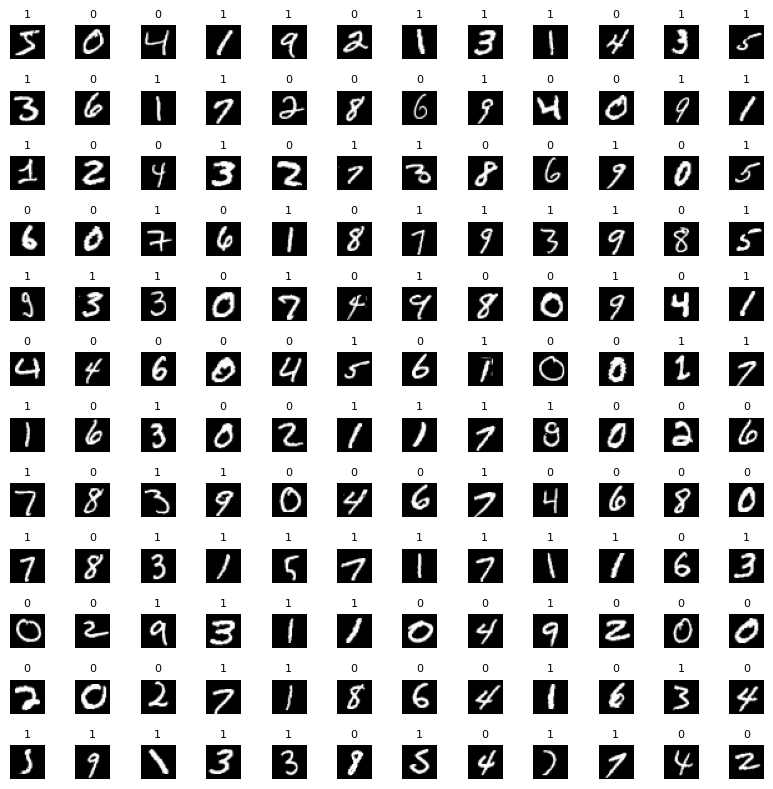

In [20]:
plt.figure(figsize=(8, 8))

for i in range(144):
    img, label = mnist_trainset[i]
    plt.subplot(12, 12, i + 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(str(label), fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [21]:
train_loader = data.DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(mnist_testset, batch_size=batch_size, shuffle=False)

In [22]:
learning_rate = 1e-3
n_epochs = 5

encoder = MLPEncoder(in_dim=28*28*1, latent_dim=16, output_neurons=()).to(device)
#encoder = ConvEncoder(in_channels=1)
classifier = Classifier(latent_dim=16).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=learning_rate)

In [23]:
# training loop
for epoch in range(n_epochs):
    encoder.train()
    classifier.train()
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        
        z = encoder(images)
        outputs = classifier(z)
        loss = criterion(outputs, labels.long())
        
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1} complete: Loss = {loss.item():.6f}")

Epoch 1 complete: Loss = 0.260675
Epoch 2 complete: Loss = 0.264833
Epoch 3 complete: Loss = 0.241247
Epoch 4 complete: Loss = 0.330218
Epoch 5 complete: Loss = 0.186770


In [24]:
all_preds = []
all_labels = []

encoder.eval()
classifier.eval()

with torch.no_grad():
    for images, labels in test_loader:
        z = encoder(images)
        outputs = classifier(z)
        preds = torch.softmax(outputs, dim=1)[:, 1] > 0.5   #(outputs > 0).long().flatten()
        preds = preds.long().flatten()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
print(classification_report(all_labels, all_preds, target_names=["Even","Odd"]))

              precision    recall  f1-score   support

        Even       0.89      0.91      0.90      4926
         Odd       0.91      0.90      0.90      5074

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [25]:
# MLP
print(classification_report(all_labels, all_preds, target_names=["Even", "Odd"]))

              precision    recall  f1-score   support

        Even       0.89      0.91      0.90      4926
         Odd       0.91      0.90      0.90      5074

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [26]:
# convolutional
print(classification_report(all_labels, all_preds, target_names=["Even", "Odd"]))

              precision    recall  f1-score   support

        Even       0.89      0.91      0.90      4926
         Odd       0.91      0.90      0.90      5074

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [27]:
# def make_soft_bias_matrix(num_classes=10, bias_strength=0.8):
#     """
#     Returns a [num_classes x num_classes] matrix, where:
#     - Diagonal entries = `bias_strength` (e.g. 0.8)
#     - Off-diagonals = (1 - bias_strength) / (num_classes - 1)
#     """
#     # off_diag = (1 - bias_strength) / (num_classes - 1)
#     # p_y_a = [[off_diag for _ in range(num_classes)] for _ in range(num_classes)]
#     # for i in range(num_classes):
#     #     p_y_a[i][i] = bias_strength
#     # return p_y_a
#     p_y_a = torch.full((num_classes, num_classes), (1 - bias_strength) / (num_classes - 1))
#     for i in range(num_classes):
#         p_y_a[i, i] = bias_strength
#     return p_y_a

In [28]:
# # CIFAR10
# p_y_a = make_soft_bias_matrix(bias_strength=0.8)
# p_y_a_list = p_y_a.tolist()

# transform = transforms.ToTensor()
# train_set = BiasedCifar10(root='../data/BiasedCifar10/', p_y_a=p_y_a_list, train=True, download=True)
# test_set = BiasedCifar10(root='../data/BiasedCifar10/', p_y_a=p_y_a_list, train=False, download=True)

In [29]:
# batch_size = 256
# train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=4)
# test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=4)


In [30]:
# n_epochs = 10
# lr = 1e-3
# encoder = ConvEncoderCIFAR(latent_dim=64, in_channels=3).to(device)
# classifier = Classifier(latent_dim=64).to(device)

# criterion = torch.nn.CrossEntropyLoss()
# optimizer = optim.Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=learning_rate)

# # 4) Training loop
# for epoch in range(1, n_epochs+1):
#     encoder.train()
#     classifier.train()
#     for images, labels in train_loader:
#         optimizer.zero_grad()
        
#         z = encoder(images)
#         outputs = classifier(z)
#         loss = criterion(outputs, labels.long())
        
#         loss.backward()
#         optimizer.step()
#     print(f"[CIFAR10] Epoch {epoch +1} complete: Loss = {loss.item():.6f}")

In [31]:
# # 5) Evaluation on the biased test set
# encoder.eval() 
# classifier.eval()

# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for imgs, labels in test_loader:
#         z = encoder(imgs.to(device))
#         outputs = classifier(z)
#         preds = outputs.argmax(dim=1).cpu() # multiclass preds = outputs.argmax(dim=1)
        
#         all_preds.extend(preds.tolist())
#         all_labels.extend(labels.tolist())

# print("\nBiased CIFAR-10 Test Results:")
# print(classification_report(all_labels, all_preds, target_names=["Even","Odd"]))